In [129]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

from qiskit import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-09-28 17:14:46,729: Credentials are already in use. The existing account in the session will be replaced.


<div align=center class="alert alert-block alert-success">
    <h1>IQOSF Mentorship Program:</h1>
        <h1>Task 1</h1>
    <h2>Abdiel Guerrero V. </h2>
</div>

<div align=center class="alert alert-block alert-info">
    <h1>Table of Contents</h1>
</div>

| |
|:-|
|    [Problem](#Problem)|
|[Example 1](#Example_1)|
|[Defining a strategy](#Estr)|
|[1. Input Vector](#Inp_Vec)|
|[2. Convert into binary representation](#Bin_rep)|
|[3. Encoding Data](#Encod_data)|
|[3.1 Creating a qRAM](#Create_qRAM)|
|[4. Grover's Algorithm](#Grover)|
|[4.1 Constructing a Oracle](#Oracle)|
|[4.2 Re-Applying the qRAM](#qRAM2)|
|[4.3 Diffuser $U_s$](#diff)|

---

<h1><a  style="color:#A510E5;" id='Problem'>Problem</a></h1>

Design a quantum circuit that considers as input the following vector of integers numbers:

$$
\begin{bmatrix}
1 & 5 & 7 & 10
\end{bmatrix}
$$

returns a quantum state which is a superposition of indices of the target solution, <code style="background:pink;color:black">obtaining in the output the indices of the inputs where two adjacent bits will always have different values</code>. In this case the output should be:

$$
\frac{1}{\sqrt{2}} \big( |01\rangle + |11 \rangle  \big)
$$

,as the correct indices are 1 and 3.

`[0]`: 1 = 0001

`[1]`: 5 = 0101

`[2]`: 7 = 0111

`[3]`: 10 = 1010

The method to follow for this task is to start from an array of integers as input, pass them to a binary representation and you need to find those integers whose binary representation is such that two adjacent bits are different. Once you have found those integers, you must output a superposition of states where each state is a binary representation of the indices of those integers.

---

<h2><a style="color:#C868C6", id='Example_1'>Example 1</a></h2>

1. Consider the vector 
$
\begin{bmatrix}
1 & 5 & 4 & 2
\end{bmatrix}
$

2. Pass the integer values to binary numbers that is `[001, 101, 100, 010]`

3. Returns the linear combination of the indices in which the values satisfying the criteria are found.

$$
[0] \implies 001 \\ 
[1] \implies 101 \\ 
[2] \implies 100 \\ 
[3] \implies 010 
$$

4. Indices are converted to binary states:

$$
001 \implies |00\rangle \\ 
101 \implies |01\rangle \\ 
100 \implies |10\rangle \\ 
010 \implies |11\rangle \\ 
$$

5. Therefore, the answer would be the superposition of the state $|01 \rangle$ and $|11\rangle$, it means

$$
\frac{1}{\sqrt{2}}\bigg(\big| 01\big\rangle + \big|11\big \rangle \bigg)
$$

---

<h1><a style="color:#A510E5", id='Estr'>Defining a strategy</a></h1>

<h2><a style="color:#C868C6", id='Inp_Vec'>1. Input Vector</a></h2>

First of all, we need to obtain our input vector. In this case, the vector is `[1, 5, 7, 10]`

In [467]:
v = np.array([1,
              5,
              7,
             10])
print(v)

[ 1  5  7 10]


<h2><a style="color:#C868C6",  id='Bin_rep'>2. Convert into binary representation</a></h2>

Then, we need to convert the previous vector into a binary form.

In [468]:
vals_ = []
for i in v:
    vals_.append((bin(i)[2:]))
vals_

['1', '101', '111', '1010']

remember that each element in the list will be related with his index when we will construct our quantum circuit.

In [469]:
for i in vals_:
    print(f'Value: {i} , Indices: {vals_.index(i)}')

Value: 1 , Indices: 0
Value: 101 , Indices: 1
Value: 111 , Indices: 2
Value: 1010 , Indices: 3


---

<h2><a style="color:#C868C6",  id='Encod_data'>3. Encoding Data</a></h2>

Each element of our input vector will be associated with an index and a quantum state in the Quantum Circuit in the next way:

$$
\begin{aligned}
1  \implies 1    &\implies  [0] \implies |00 \rangle \\ 
5  \implies 101  &\implies  [1] \implies |01 \rangle \\
7  \implies 111  &\implies  [2] \implies |10 \rangle \\
10 \implies 1010 &\implies [3] \implies |11 \rangle \\
\end{aligned}
$$

In this case, we will need  2 qubits to encode our data directions, i.e. ($|00\rangle$, $|01\rangle$, $\cdots$); and $2^2$ qubits to express our binary values, the necessary ones to construct our next qRAM .

The premise that our quantum circuit needs is try to find those integers whose binary representation are such that, two adjacent bits, representing our binary values; be different.

$$
\begin{aligned}
1    &\implies  0001 \implies |00 \rangle \\ 
101  &\implies  0101 \implies |01 \rangle \\
111  &\implies  0111 \implies |10 \rangle \\
1010 &\implies  1010 \implies |11 \rangle \\
\end{aligned}
$$

so, we will fill our data with zeros to the left side:

In [470]:
for i in range(4):
    vals_[i] = vals_[i].zfill(4)
vals_

['0001', '0101', '0111', '1010']

Remember that we need the superposition of the states which accomplish the condition, so we need to put it into a superposition before to pass to the encoding part.

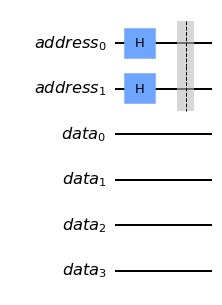

In [471]:
index_reg = QuantumRegister(2, name='address')
bin_vals  = QuantumRegister(4, name='data')
qc = QuantumCircuit(index_reg,bin_vals)

qc.h(index_reg)
qc.barrier(index_reg)

qc.draw('mpl')

then, we introduce our encoding part trying to obtain the output

$$
\frac{1}{2} 
\bigg( 
|00\rangle |0001\rangle +
|01\rangle |0101\rangle + 
|10\rangle |0111\rangle + 
|11\rangle |1010\rangle  \bigg)
$$

To be able to make this search trying to find the states whose binary representation accomplish the condition, <code style="background:pink;color:black">we will use a qRAM and Grover's algorithm to perform this search over a subset of our possible states</code>.

<table>
    <tr>
        <th>
            <img src="https://i.imgur.com/PgFtlgq.png" width="384px"/>
        </th>
    </tr>
    <tr>
        <th>
            Our expected qRAM 
        </th>
    </tr>
</table>

where,

<table>
    <tr>
        <th>
            <img src="https://i.imgur.com/cpIFA4N.png" width="384px"/>
        </th>
    </tr>
    <tr>
        <th>
            Equivalence
        </th>
    </tr>
</table>

<h2><a style="color:#C868C6",  id='Create_qRAM'>3.1 Creating qRAM</a></h2>

In [472]:
print(vals_)

['0001', '0101', '0111', '1010']


00
j: 0, val: 0, counter: 3
j: 1, val: 0, counter: 2
j: 2, val: 0, counter: 1
j: 3, val: 1, counter: 0
01
j: 0, val: 0, counter: 3
j: 1, val: 1, counter: 2
j: 2, val: 0, counter: 1
j: 3, val: 1, counter: 0
10
j: 0, val: 0, counter: 3
j: 1, val: 1, counter: 2
j: 2, val: 1, counter: 1
j: 3, val: 1, counter: 0
11
j: 0, val: 1, counter: 3
j: 1, val: 0, counter: 2
j: 2, val: 1, counter: 1
j: 3, val: 0, counter: 0


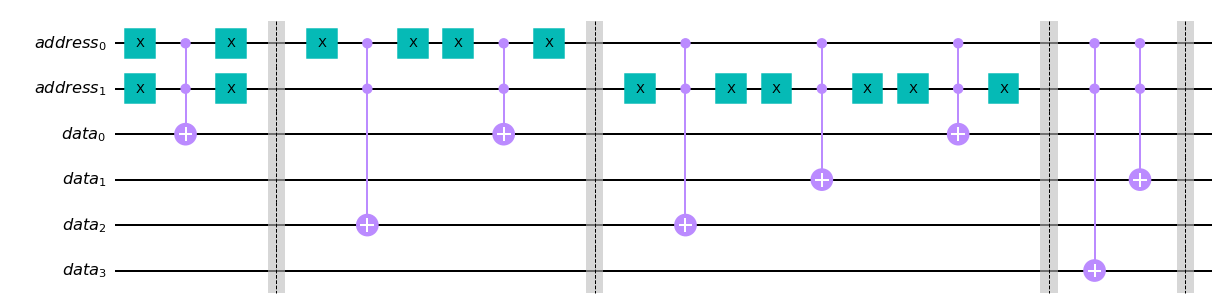

In [473]:
address_reg = QuantumRegister(np.sqrt(len(vals_)), name='address')
binary_reg  = QuantumRegister(len(vals_), name='data')

qc = QuantumCircuit(address_reg,binary_reg)

n = len(vals_)

for indx in range(n):
    
    # Create adrress indices
    bin_indx = bin(4 + indx)[-2:]
    print(bin_indx)
    
    count = len(vals_[indx])-1
    for j, val in enumerate(vals_[indx]):
        print(f'j: {j}, val: {val}, counter: {count}')
        
        if val == '1':
            if bin_indx[0] == '0':
                qc.x(0)
            if bin_indx[1] == '0':
                qc.x(1)
            qc.ccx(0,1, binary_reg[count])
            if bin_indx[0] == '0':
                qc.x(0)
            if bin_indx[1] == '0':
                qc.x(1)
        count = count -1
    qc.barrier()

qc.draw('mpl')    

once we check that it is the circuit that we expect, we will put all within a function that returns a gate.

In [474]:
def q_RAM(n, reg_1, reg_2):
    
    qc = QuantumCircuit(reg_1,reg_2)
    for indx in range(n):

        # Create adrress indices
        bin_indx = bin(4 + indx)[-2:]

        count = len(vals_[indx])-1
        for j, val in enumerate(vals_[indx]):        
            if val == '1':
                if bin_indx[0] == '0':
                    qc.x(0)
                if bin_indx[1] == '0':
                    qc.x(1)
                qc.ccx(0,1, reg_2[count])
                if bin_indx[0] == '0':
                    qc.x(0)
                if bin_indx[1] == '0':
                    qc.x(1)
            count = count -1 
    gate = qc.to_gate()
    gate.name = 'qRAM'
    return gate  

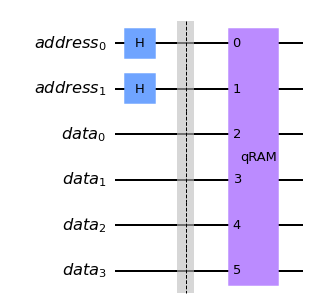

In [475]:
address_reg_ = QuantumRegister(np.sqrt(len(vals_)), name='address')
binary_reg_  = QuantumRegister(len(vals_), name='data')
qc_ = QuantumCircuit(address_reg_ ,binary_reg_)
n_ = len(vals_)


qc_.h(address_reg)
qc_.barrier()


qc_.append( q_RAM(n_, address_reg_, binary_reg_), range(6) )
qc_.draw('mpl')

<h2><a style="color:#C868C6",  id='Grover'>4. Grover's Algorithm</a></h2>

Now, its time to select a subset of our all possible values in the superposition. It means, we need to select only the addresses that are correlated such that,their binary values relative to another adrress binary values are all different.

$$
\begin{aligned}
1     \implies  |00 \rangle   &\implies  &0&0&0&1  \\ 
                              &          && |& &   \\
101   \implies  |01 \rangle   &\implies  &0&1&0&1  \\
                              &          & & &| &   \\
111   \implies  |10 \rangle   &\implies  &0&1&1&1  \\
                              &          &|&|& &|   \\
1010  \implies  |11 \rangle   &\implies  &1&0&1&0  \\
\end{aligned}
$$

$$
\begin{aligned}
101   \implies  |01 \rangle   &\implies  &0&1&0&1  \\
                              &          &|&|&|&|   \\
1010  \implies  |11 \rangle   &\implies  &1&0&1&0  \\
\end{aligned}
$$

<h2><a style="color:#C868C6",  id='Oracle'>4.1 Constructing an Oracle</a></h2>

In this step we need to apply an oracle over our `data register`, such that we change the sign of the values that satisfy the condition and then, mark the corresponding value in the `address register`.

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \neq \omega \\
-|x\rangle \quad \text{if} \; x = \omega \\
\end{aligned}
$$

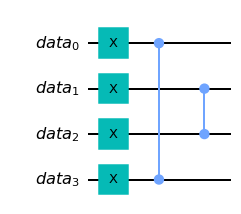

In [476]:
binary_reg  = QuantumRegister(len(vals_), name='data')
qc = QuantumCircuit(binary_reg)
n = len(vals_)


for i in range(n):
    qc.x(i)
qc.cz(binary_reg_[0], binary_reg_[n-1])
qc.cz(binary_reg_[1], binary_reg_[n-2])
qc.draw('mpl')

In [477]:
def oracle(n, reg_2):
    for indx in range(n-2):
        qc.cx(reg_2[indx], reg_2[indx+1])

    qc.cz(binary_reg_[n-2], binary_reg_[n-1])
    gate = qc.to_gate()
    gate.name = 'Oracle'
    return gate

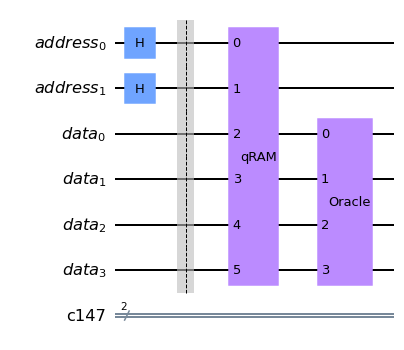

In [478]:
address_reg_ = QuantumRegister(np.sqrt(len(vals_)), name='address')
binary_reg_  = QuantumRegister(len(vals_), name='data')
meas_reg_   =  ClassicalRegister(size=np.sqrt(len(vals_)), name=None, bits=None)

qc_ = QuantumCircuit(address_reg_ ,binary_reg_, meas_reg_)
n_ = len(vals_)


qc_.h(address_reg)
qc_.barrier()

qc_.append( q_RAM(n_, address_reg_, binary_reg_),  range(6) )
qc_.append( oracle(n_,binary_reg_), range(2,6) )

#qc_.measure(address_reg_, meas_reg_)
qc_.draw('mpl')

<h2><a style="color:#C868C6",  id='qRAM2'>4.2 Re-Applying the qRAM</a></h2>

Next, we need to apply the `qRAM` again to eliminate any possible entanglement in our next Grover's Gate and move from values to addresses.

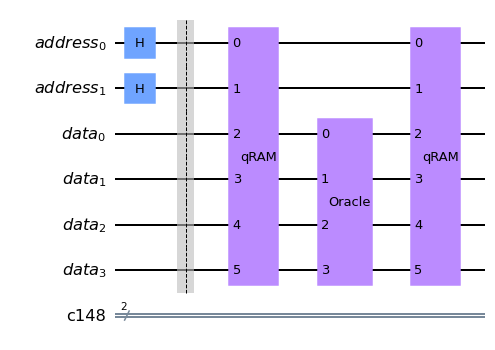

In [479]:
address_reg_ = QuantumRegister(np.sqrt(len(vals_)), name='address')
binary_reg_  = QuantumRegister(len(vals_), name='data')
meas_reg_   =  ClassicalRegister(size=np.sqrt(len(vals_)), name=None, bits=None)

qc_ = QuantumCircuit(address_reg_ ,binary_reg_, meas_reg_)
n_ = len(vals_)

### Superposition ###
qc_.h(address_reg)
qc_.barrier()

### qRAM ###
qc_.append( q_RAM(n_, address_reg_, binary_reg_),  range(6) )
### Oracle ###
qc_.append( oracle(n_,binary_reg_), range(2,6) )
### qRAM ###
qc_.append( q_RAM(n_, address_reg_, binary_reg_),  range(6) )


#qc_.measure(address_reg_, meas_reg_)
qc_.draw('mpl')

<h2><a style="color:#C868C6",  id='diff'>4.3 Diffuser $U_s$</a></h2>

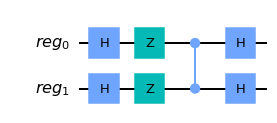

In [480]:
rang_ = int(np.sqrt(n_))
reg  = QuantumRegister(rang_, name='reg')
qc_2 = QuantumCircuit(reg)

qc_2.h(reg)
qc_2.z(reg)
for i in range(rang_ - 1 ):
    qc_2.cz(reg[i-1], reg[i])
qc_2.h(reg)

qc_2.draw('mpl')

In [481]:
difusor = QuantumCircuit(rang_ , name= 'diff')
difusor.h(range(rang_))
difusor.z(range(rang_))
for i in range(rang_ - 1 ):
    difusor.cz(i, i+1 )
    
difusor.h(range(rang_))
diff_gate = difusor.to_gate()
diff_gate.name = 'diff'

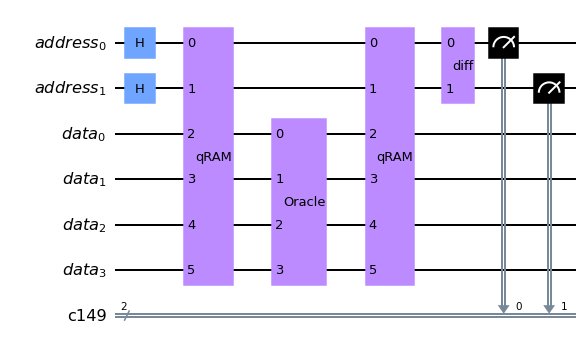

In [482]:
n_ = len(vals_)
rang_ = int(np.sqrt(n_))

address_reg_ = QuantumRegister(np.sqrt(len(vals_)), name='address')
binary_reg_  = QuantumRegister(len(vals_), name='data')
meas_reg_   =  ClassicalRegister(size=np.sqrt(len(vals_)), name=None, bits=None)


qc_ = QuantumCircuit(address_reg_ ,binary_reg_, meas_reg_)


### Superposition ###
qc_.h(address_reg)


### qRAM ###
qc_.append( q_RAM(n_, address_reg_, binary_reg_),  range(6) )
### Oracle ###
qc_.append( oracle(n_,binary_reg_), range(2,6) )
### qRAM ###
qc_.append( q_RAM(n_, address_reg_, binary_reg_),  range(6) )

qc_.append(diff_gate, range(2))

qc_.measure(address_reg_, meas_reg_)
qc_.draw('mpl')

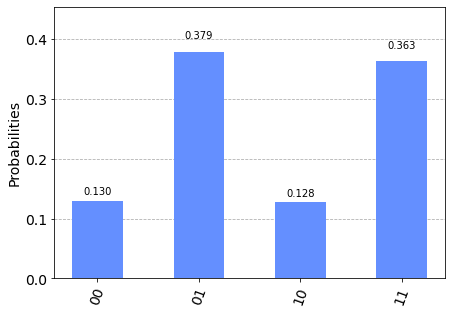

In [483]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc_, backend, shots = 10000)
plot_histogram(job.result().get_counts())

it doesn't work for any input, but for now, it is the closest answer that I have.

---